# Analysis of Monte Carlo simulations of mutation accumulation 

Written by [Peter McHale](http://ccbs-76.bio.uci.edu/~petermchale/) 

This Notebook lives at [Github](https://github.com/petermchale/mutation_accumulation/tree/master/example). Follow these [easy-to-follow instructions](http://jupyter.readthedocs.io/en/latest/install.html)
to execute the Notebook using Python. Otherwise, [view this Notebook](http://nbviewer.jupyter.org/github/petermchale/mutation_accumulation/blob/master/example/analysis.ipynb) in read-only mode using [Jupyter Notebook Viewer](http://nbviewer.jupyter.org). 

In [1]:
import datetime
print('the current date is: ') 
print(datetime.date.today())

the current date is: 
2016-10-11


Many adult tissues renew themselves continually via a pool of cells called stem cells. Stem cell divisions are either asymmetric—in which one daughter cell remains a stem cell and one does not—or symmetric, in which both daughter cells adopt the same fate, either stem or non-stem. Recent studies show that in many tissues stem cell division patterns are strongly biased toward the symmetric outcome, raising the question of whether symmetry confers some benefit. 

The DNA of stem cells is continually subject to damage. For example, errors occur in DNA when it is replicated, and if this damage is not repaired it can lead to cancer. In [this publication](http://journals.plos.org/ploscompbiol/article?id=10.1371%2Fjournal.pcbi.1003802), we showed that symmetry, via extinction of damaged stem-cell clones, reduces the lifetime risk of accumulating phenotypically silent heritable damage (mutations or aberrant epigenetic changes) in individual stem cells. 

That work focused on the homeostatic case in which stem cells, though dividing, do not change their number, e.g., as occurs in the adult intestine. Here, I assess the expected rate of mutation accumulation in a non-homeostatic tissue, e.g. a developing tumor. 

One non-homeostatic model of mutation accumulation is a discrete-time multi-type branching process. The stochastic process starts with a number of wild-type stem cells, each cell accumulates mutations at each of $K$ different genes, and the process ends when the first stem cell with $K$ mutations arises.  Under this model, the division of a stem cell $S_i$ with $i = 0 \ldots K-1$ mutations results in one of five possible outcomes with the following probabilities:

\begin{equation}
S_i \xrightarrow{\hspace{1cm}} 
\left\{
\begin{array}{lcrcl}
S_i + S_i & & & \mbox{with prob.} & rs (1-2u_i) \\
S_i + S_{i+1} & & & \mbox{with prob.} &  rs \, 2 u_i \\
S_i & & & \mbox{with prob.}&(1-s) (1-u_i) \\
S_{i+1} & & & \mbox{with prob.}&(1-s)u_i \\
\emptyset & & & \mbox{with prob.}&(1-r)s
\end{array}
\right.
\end{equation}

Here, the fraction of divisions that are symmetric — producing daughter cells with a common fate — is denoted $s$; the mutation rate for a stem cell with $i$ mutations is denoted $u_i$; and $r$ measures the imbalance of symmetric renewal versus symmetric differentiation. 

To simulate this stochastic process, I used [`mutation_accumulation`](https://github.com/petermchale/mutation_accumulation), following [these instructions](https://github.com/petermchale/mutation_accumulation/blob/master/README.md). The following is some data output from the Monte Carlo simulation. It is a time course tracking the predicted number of wild-type (blue; 0 mutations), single-mutant (green), and double-mutant stem cells (red) prior to the appearance of the first triple-mutant stem cell (not shown).

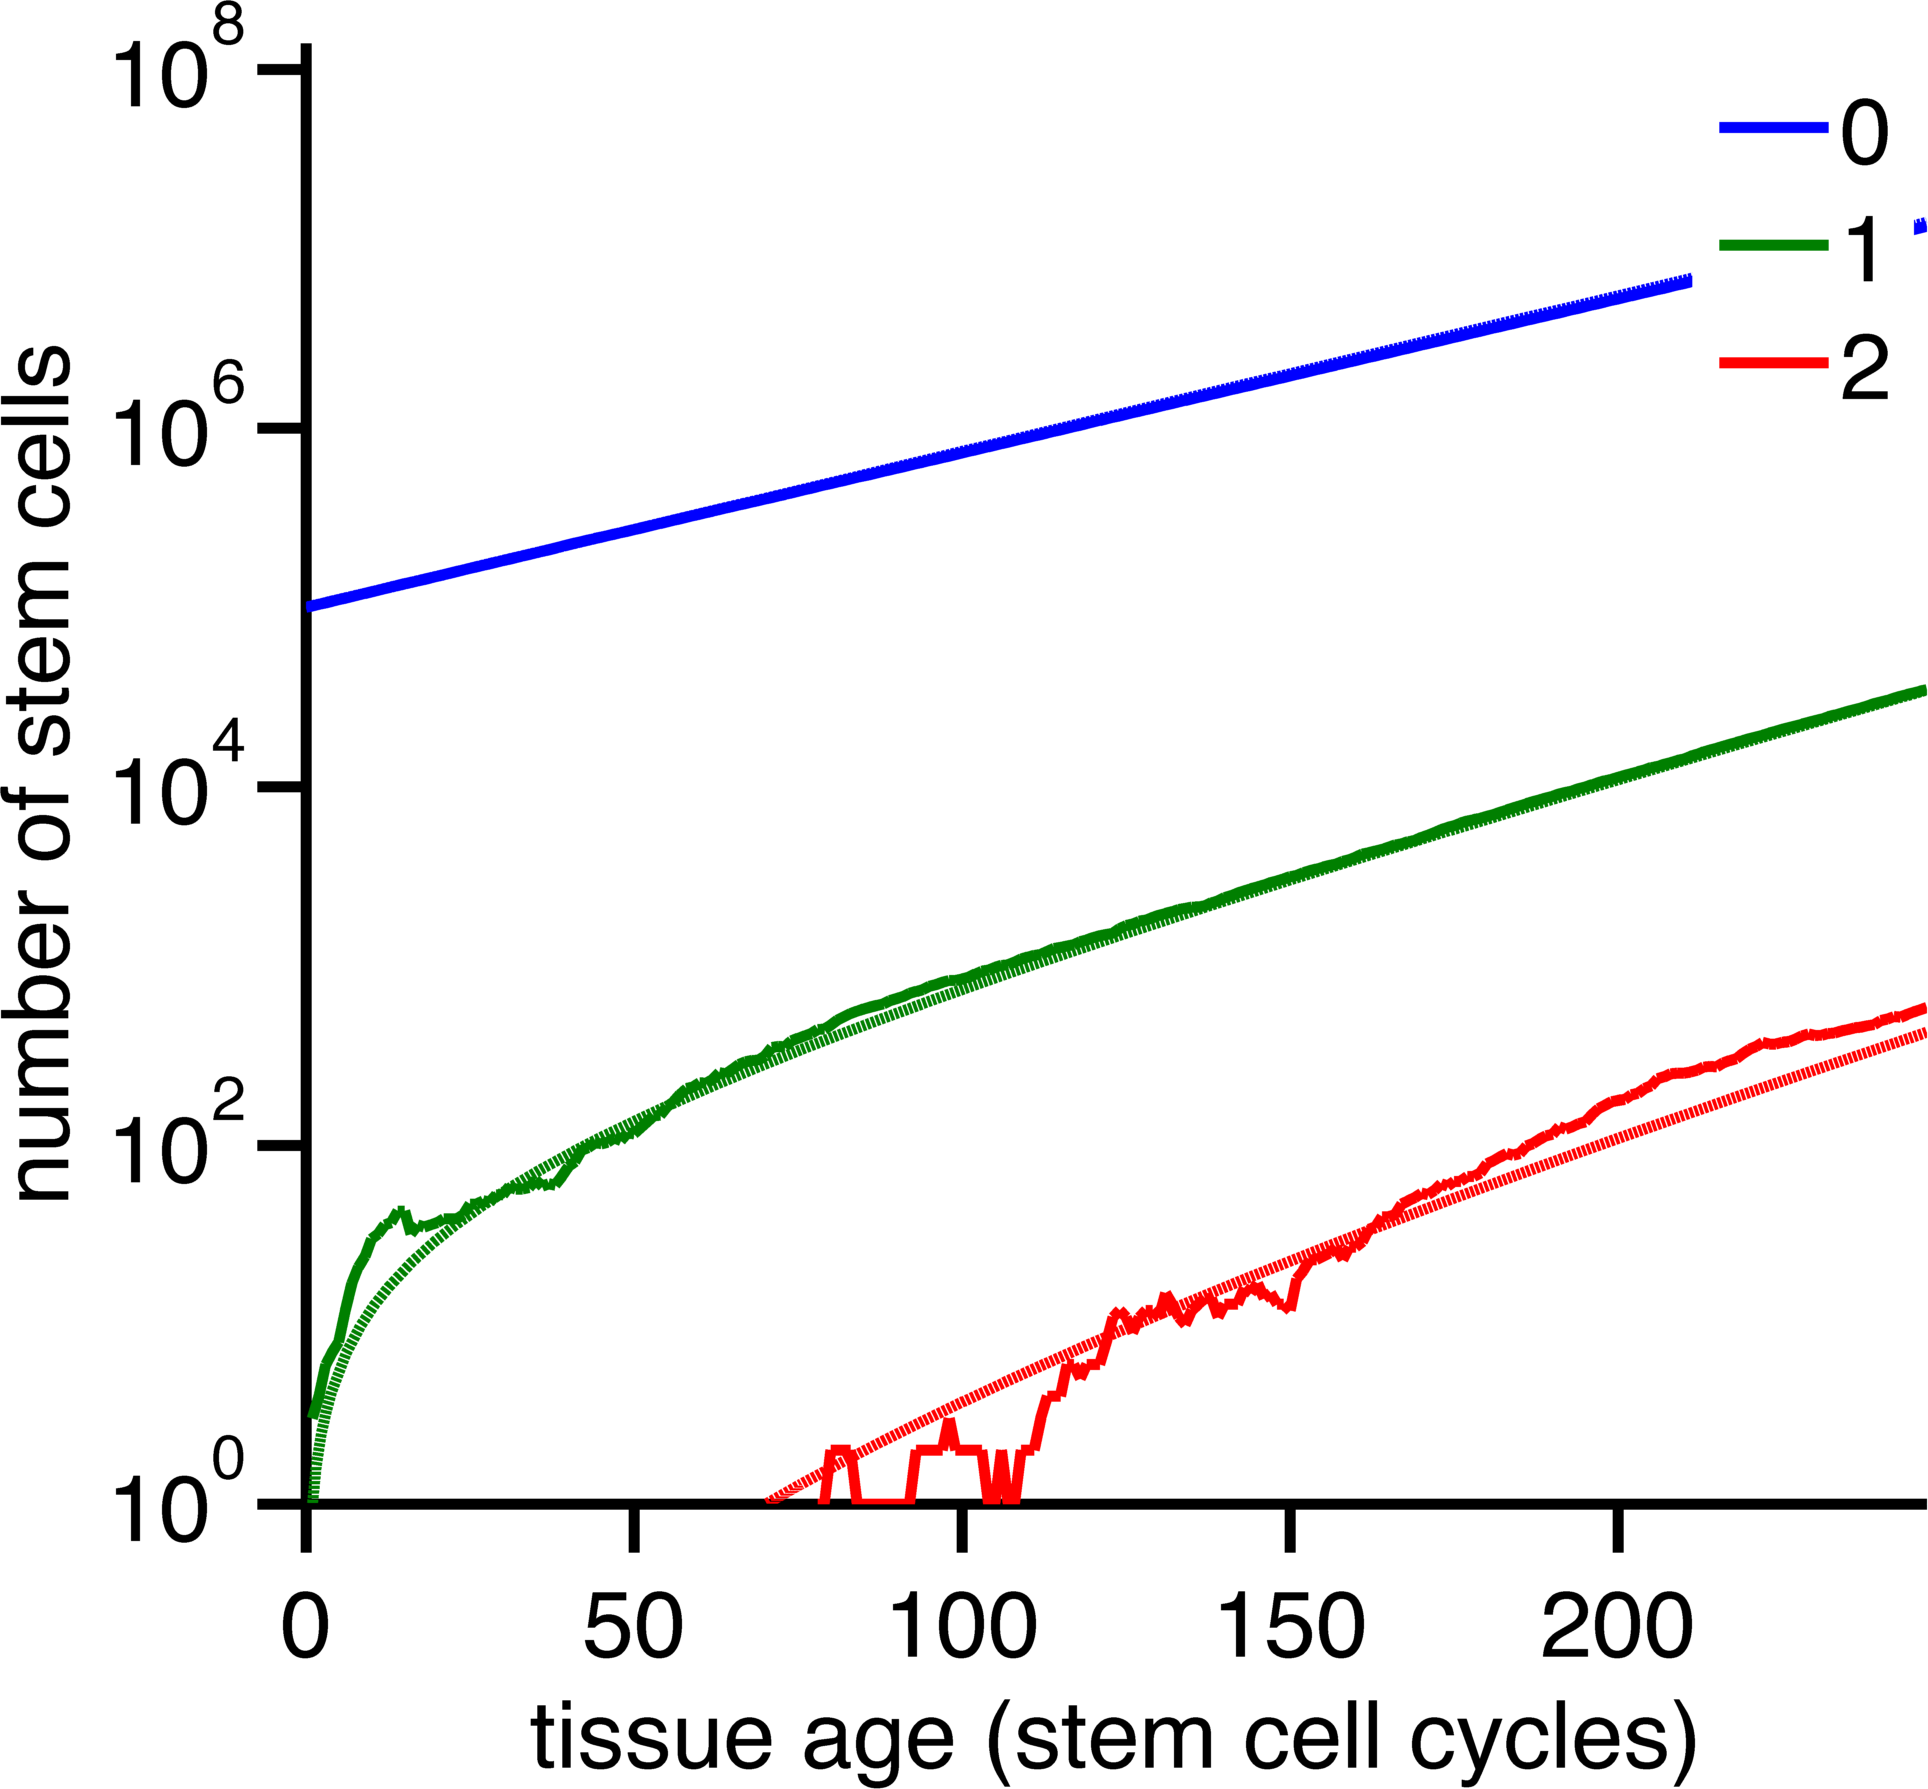

In [8]:
from IPython.display import Image
Image(filename="trajectories.png", width=350, height=350)

The jagged lines represent the fluctuating output of the Monte Carlo simulation while the solid lines represent the predictions of a deterministic model of mutation accumulation described by the following dynamical equations

\begin{equation} 
dn_i/dt = n_{i-1}u_{i-1} + n_i \nu
\end{equation} 

where $n_i$ represents the average number of stem cells with $i$ mutations, and $\nu = (2r-1)s$ represents the average tumor growth rate. As you can see, the agreement between simulation and the formula is good. What the formula doesn't predict, however, but which the simulation does, is the probability that a  tissue of a given age contains at least one stem cell with $K$ mutations: 

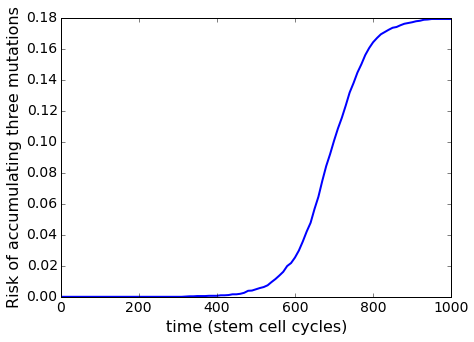

In [21]:
import numpy as np 
data = np.loadtxt('data/cdf/histogram__pop0__spe3__xxx0.dat')

from matplotlib import pyplot as plt
%matplotlib inline

fontsize = 16
fontsize_tick = 14

fig = plt.figure(figsize=(7,5), facecolor='w')
ax = fig.add_subplot(111)
ax.plot(data[:,0], data[:,1], linewidth=2)
ax.set_xlabel('time (stem cell cycles)', fontsize=fontsize)
ax.set_ylabel('Risk of accumulating three mutations', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

Notice that the probability of there being at least one stem cell with three mutations saturates with increasing time at a value less than 1. The explanation is that these simulations were performed with an initial condition of just one stem cell, as would occur during tumor progression. Under these circumstances, it is very likely that all stem cells in the tumor differentiate before mutations have had a chance to accumulate. 